In [187]:
# Setting up everything
import torch
import hashlib
from scipy.optimize import brute
import numpy as np
import numpy.random as rand
import json
from datetime import datetime
from datetime import date
from sklearn import preprocessing
import csv
from dateutil import parser

import importlib
import tickstore
from tickstore.query import QuerySettings, QueryFunctor, TickSampler
from matplotlib import pyplot as plt
c = tickstore.Client("127.0.0.1:4501")

import perpx
import utils

In [239]:
FROM_TRAIN = 1616000000000
TO_TRAIN   = 1619000000000
importlib.reload(perpx)
qs = QuerySettings(
    streaming=False,
    batch_size=1000,
    timeout=1000000,
    selector='SELECT Trade(trade) WHERE type="^CRSPOT$" base="^ETH$" quote="^USD$" exchange="^coinbasepro$"',
    frm=FROM_TRAIN-1,
    to=TO_TRAIN,
)

ex = perpx.Instrument(0.01)
dur = (TO_TRAIN - FROM_TRAIN) / (1000 * 60 * 60 * 24)
print(dur)
prices = []
ex.provide(100000000)
x = []
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []
q = c.new_query(qs)
lastTick = 0
tot = 0
vol = 0
vol2 = 0
start = None
end = None
while q.next():
    tick, trade, _ = q.read()
    if start is None:
        start = tick
    end = tick
    size = rand.normal(0, np.abs(trade.size()))
    tot += size
    vol += np.abs(size)
    vol2 += np.abs(trade.size())
    ex.trade(1, size)
    if tick - lastTick > 1000:
        lastTick = tick
        ex.update_price(trade.price())
        ex.capture(tick)
print(utils.sharpe(np.square(np.array(ex.y1)), 1000))

34.72222222222222
12.73250638031284


In [237]:
print(vol2 * 2300)

16187775247.236542


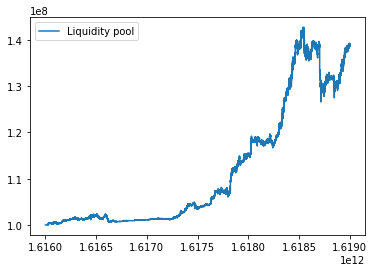

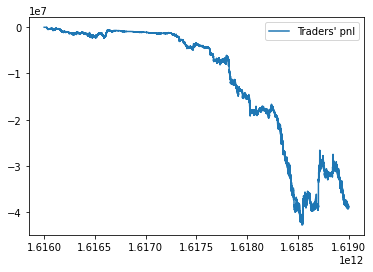

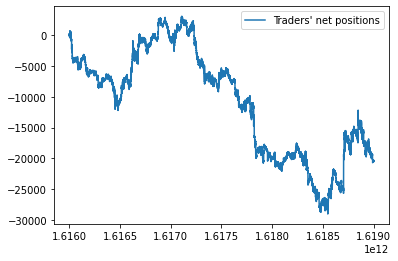

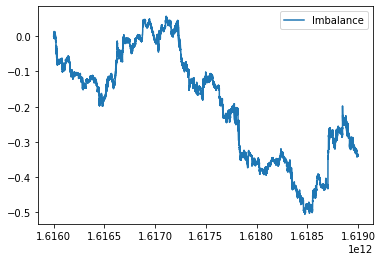

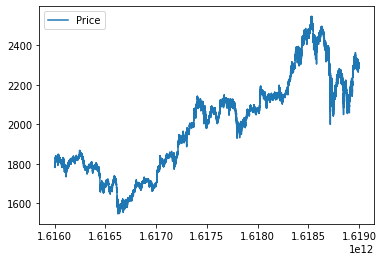

In [240]:
ex.plot()

In [208]:
print(utils.sharpe(np.square(np.array(ex.y1)), 1000))

1.1710947729722656


In [29]:
importlib.reload(perpx)
ex = perpx.Instrument()

rand.normal(0, 1)
price = 100.
ex.provide(10000)
x = []
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []
dailyVolume = 1000000
secondVolume = dailyVolume / (60. * 60. * 24.)
tot = 0
for i in range(30000):
    size = rand.normal(0, secondVolume)
    tot += np.abs(size)
    pricechng = np.exp(rand.normal(0, 0.01))
    price *= (pricechng - (0.001 * ((price / 100.) - 1.)))
    #print((0.001 * (ex.imbalance())) + 1.)
    bef = size
    if size < 0:
        size *= ((ex.imbalance())) + 1.
    else:
        size /= ((ex.imbalance())) + 1.
    #print(size/price)
    #print(price)
    #print(size)
    ex.trade(1, size/price)
    ex.update_price(price)
    x.append(i)
    y1.append(ex.pool())
    y2.append(ex.pnl(1))
    y3.append(ex.oi)
    y4.append(ex.imbalance())
    y5.append(price)

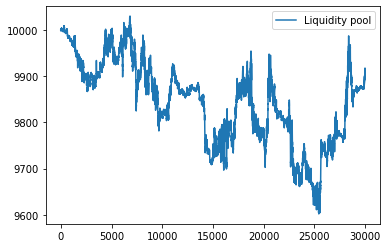

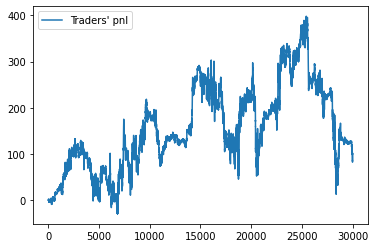

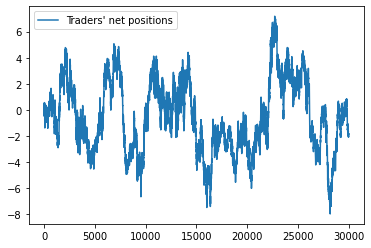

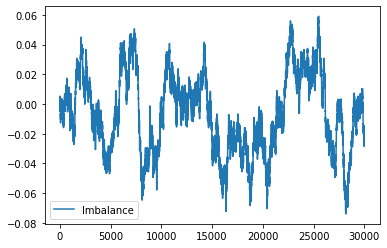

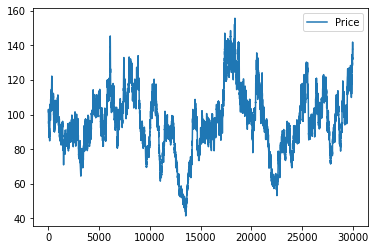

In [11]:
plt.plot(x, y1, label="Liquidity pool")
plt.legend()
plt.show()
plt.plot(x, y2, label="Traders' pnl")
plt.legend()
plt.show()
plt.plot(x, y3, label="Traders' net positions")
plt.legend()
plt.show()
plt.plot(x, y4, label="Imbalance")
plt.legend()
plt.show()
plt.plot(x, y5, label="Price")
plt.legend()
plt.show()

In [135]:
with open("data.json") as f:
    pika = json.load(f)

In [136]:
print(pika[-1])

{'open-position': None, 'close-position': {'position-id': 109945779719214196280518666201040821547967767029168157989879288324735625787591, 'user': '0xc573a808275e2c7cf9399ed2484677df345145e5', 'product-id': 1, 'price': 182236607125, 'entry-price': 299703868324, 'oracle-price': None, 'margin': 5992000000, 'leverage': 100000000, 'fee': 289403881, 'pnl': -2348531011, 'was-liquidated': False}, 'add-margin': None, 'position-liquidated': None, 'staked': None, 'redeemed': None, 'block-number': 19709025}


In [241]:
productToPair = {1: "ETH-USD", 2:"BTC-USD", 3:"LINK-USD", 4:"SNX-USD", 5: "SOL-USD", 6: "AVAX-USD", 8: "LUNA-USD", 9: "AAVE-USD"}

MAX 36846699.195491605


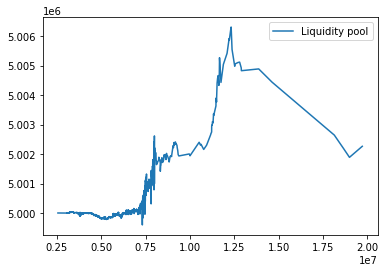

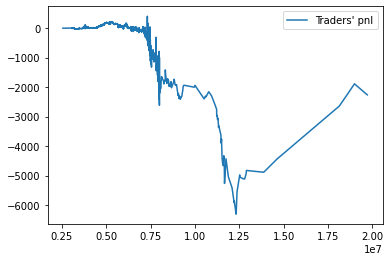

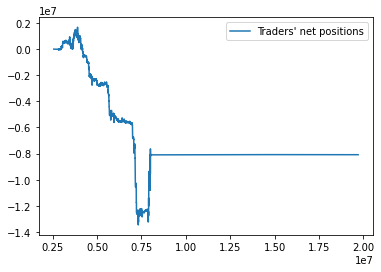

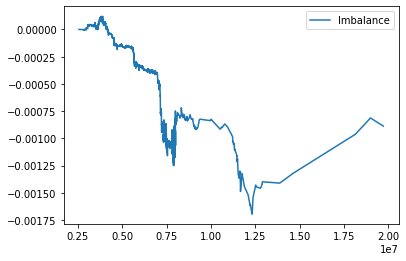

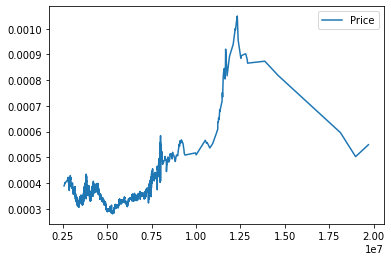

No handles with labels found to put in legend.


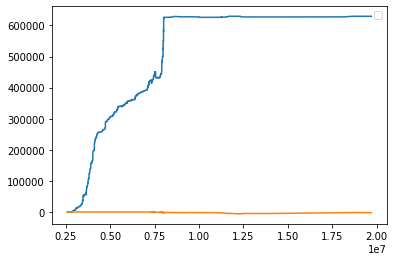

In [275]:
importlib.reload(perpx)
instrument = perpx.Instrument(0.01)
size = {}
tot = 0.
pl = 0.
product = 1
instrument.provide(5000000)
mx = 0
totpnl = 0.
xs = []
pnls = []
for p in pika:
    if p['staked']:
        amount = p['staked']['amount'] / 1e8
        #instrument.provide(amount)
        pl += amount
        if pl > mx:
            mx = pl
    if p['redeemed']:
        amount = p['redeemed']['amount'] / 1e8
        #instrument.redeem(amount)
        pl += amount
    if p['open-position']:
        productID = p['open-position']['product-id']
        if productID != product:
            continue
        user = p['open-position']['user']
        price = p['open-position']['price']
        margin = p['open-position']['margin']
        leverage = p['open-position']['leverage']
        positionID = p['open-position']['position-id']
        fee = p['open-position']['fee']
        
        #print(positionID)
        long = p['open-position']['is-long']
        notional = (margin / 1e8) * (leverage / 1e8)
        # in pika, long is short
        if long:
            notional *= -1
            
        size[positionID] = notional
        instrument.trade(user, notional)
        # OI is in notional, traders are longing USD/ETH or shorting USD/ETH, with USD as collateral
        # 
        instrument.update_price(1e8/price)
        #instruments[productID].costs[user] += fee
        instrument.capture(p['block-number'])
        tot += abs(notional)
        
        #print(instruments[productID].pool())
    if p['close-position']:
        productID = p['close-position']['product-id']
        if productID != product:
            continue
        user = p['close-position']['user']
        price = p['close-position']['price']
        margin = p['close-position']['margin']
        leverage = p['close-position']['leverage']
        positionID = p['close-position']['position-id']
        notional = (margin / 1e8) * (leverage / 1e8)
        pnl = p['close-position']['pnl']
        totpnl += (pnl / 1e8)
        if size[positionID] > 0:
            notional *= -1
        size[positionID] += notional
        
        #print(size[positionID]*-1, notional/price)
        #print(instruments[productID].pos[user])
        #print(notional/price)
        #print(p['close-position'])
        #print(notional)
        
        xs.append(p['block-number'])
        pnls.append(totpnl)
        instrument.trade(user, notional)
        instrument.update_price(1e8/price)
        instrument.capture(p['block-number'])
        tot -= abs(notional)
print("MAX", mx)
instrument.plot()
plt.plot(xs, pnls)
plt.plot(instrument.x, instrument.y2)
#plt.plot(instrument.x[:1000], instrument.y1[:1000], label="Liquidity pool")
plt.legend()
plt.show()

9997261.818871459


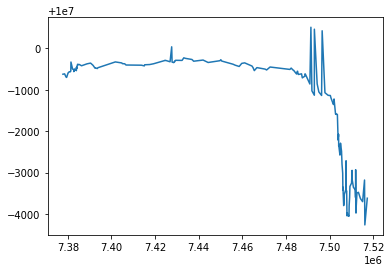

In [254]:
plt.plot(instrument.x[800:1000], instrument.y1[800:1000], label="Liquidity pool")
print(instrument.y1[1000])

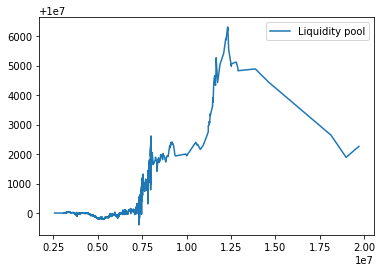

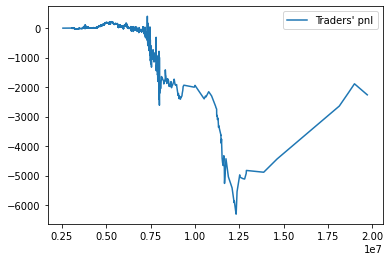

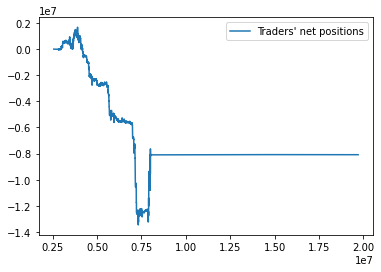

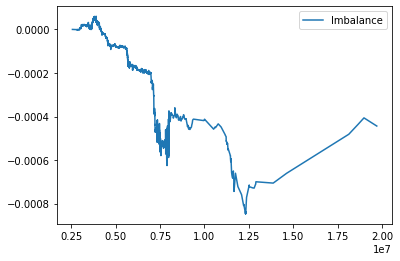

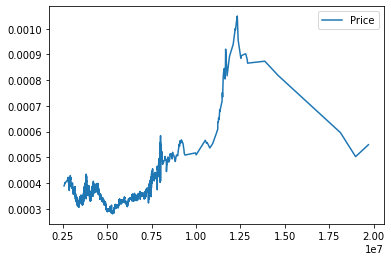

In [248]:
importlib.reload(perpx)
instrument = perpx.Instrument(0.01)
size = {}
tot = 0.
pl = 0.
instrument.provide(10000000)
for p in pika:
    if p['staked']:
        amount = p['staked']['amount'] / 1e8
        #instrument.provide(amount)
        pl += amount
    if p['redeemed']:
        amount = p['redeemed']['amount'] / 1e8
        #instrument.redeem(amount)
        pl += amount
    if p['open-position']:
        productID = p['open-position']['product-id']
        if productID != 1:
            continue
        user = p['open-position']['user']
        price = p['open-position']['price']
        margin = p['open-position']['margin']
        leverage = p['open-position']['leverage']
        positionID = p['open-position']['position-id']
        fee = p['open-position']['fee']
        
        #print(positionID)
        long = p['open-position']['is-long']
        notional = (margin / 1e8) * (leverage / 1e8)
        # in pika, long is short
        if long:
            notional *= -1
            
        size[positionID] = notional
        instrument.trade(user, notional)
        instrument.update_price(1e8/price)
        #instruments[productID].costs[user] += fee
        instrument.capture(p['block-number'])
        tot += abs(notional)
        
        #print(instruments[productID].pool())
    if p['close-position']:
        productID = p['close-position']['product-id']
        if productID != 1:
            continue
        user = p['close-position']['user']
        price = p['close-position']['price']
        margin = p['close-position']['margin']
        leverage = p['close-position']['leverage']
        positionID = p['close-position']['position-id']
        notional = (margin / 1e8) * (leverage / 1e8)
        if size[positionID] > 0:
            notional *= -1
        size[positionID] += notional
        
        #print(size[positionID]*-1, notional/price)
        #print(instruments[productID].pos[user])
        #print(notional/price)
        #print(p['close-position'])
        #print(notional)
        
        instrument.trade(user, notional)
        instrument.update_price(1e8/price)
        instrument.capture(p['block-number'])
        tot -= abs(notional)

instrument.plot()

In [127]:
(109985527 / 1e8) * (69100000000 / 1e8)  

759.9999915699999

[[-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 ...
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]
 [-5.   -4.75 -4.5  ...  4.25  4.5   4.75]]
(40, 40) (40, 40) (40, 40)


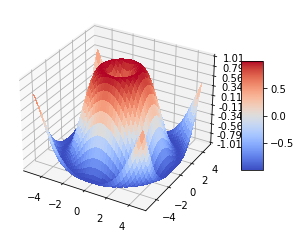

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
print(X)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(X.shape, Y.shape, Z.shape)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()